# Assignment:-


# Applying GBDT and RF on Amazon Fine Food Reviews Analysis

## Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# 1. Objective:
Given a review, determine whether the review is positive Rating (4 or 5) or negative rating (1 or 2). Use BoW, TF-IDF, Avg-Word2Vec,TF-IDF-Word2Vec to vectorise the reviews. 
Apply GBDT and Random Forest Algorithm for Amazon fine food Reviews
find right baselearners using cross validation
Get feature importance for positive class and Negative class

In [1]:
# loading required libraries 
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import gensim
import scipy 
import nltk
import time
import seaborn as sns 
from scipy import stats
from matplotlib import pyplot as plt 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as prf1

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


## 1.1 Connecting SQL file

In [2]:
#Loading the data
con = sqlite3.connect('./final.sqlite')

data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)

In [3]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


## 1.2 Data Preprocessing

In [4]:
data.Score.value_counts()
#i had done data preprocessing i had stored in final.sqlite now loaded this file no need to do again data preprocessing


positive    307061
negative     57110
Name: Score, dtype: int64

## 1.3 Sorting the data

In [5]:
# Sorting the data according to the time-stamp
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.4 Mapping

In [6]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative
sorted_data.head()


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.5 Taking First 150k rows

In [7]:
# We will collect different 150000 rows without repetition from time_sorted_data dataframe
my_final = sorted_data[:150000]
print(my_final.shape)
my_final.head()

(150000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.6 Spliting data into train and test based on time (70:30)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


x=my_final['CleanedText'].values
y=my_final['Score']

#Splitting data into train test and cross validation 
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size =0.3,random_state = 42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(105000,)
(45000,)
(105000,)
(45000,)


## 2.  Techniques For Vectorization

## Why we have to convert text to vector
By converting text to vector we can use whole power of linear algebra.we can find a plane to seperate

## 2.1 BOW

In [9]:
#Bow

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() 
final_counts_Bow_tr= count_vect.fit_transform(x_train)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_tr))
print("the shape of out text BOW vectorizer ",final_counts_Bow_tr.get_shape())
print("the number of unique words ", final_counts_Bow_tr.get_shape()[1])
final_counts_Bow_test= count_vect.transform(x_test)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_test))
print("the shape of out text BOW vectorizer ",final_counts_Bow_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (105000, 38300)
the number of unique words  38300
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (45000, 38300)


## 2.2 Normalizing Data

In [10]:
# Data-preprocessing: Normalizing Data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_Bow_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_Bow_test)
print(standardized_data_test.shape)


(105000, 38300)
(45000, 38300)


## 2.3 Applying RandomForest Algorithm


In [11]:
#Gridsearch Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

base_learners = [40,60,80,100,120]
depth=[3,5,7,9,11]
param_grid = {'n_estimators': base_learners,'max_depth':depth}
rf = RandomForestClassifier(min_samples_leaf=5,max_features='sqrt',criterion='gini',random_state = 100,class_weight ='balanced')
model = GridSearchCV(rf, param_grid,scoring ='f1',cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train,y_train)
print(model.best_score_, model.best_params_) 
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))

a = model.best_params_
optimal_estimator = a.get('n_estimators')
optimal_depth = a.get('max_depth')

0.9169864843830612 {'max_depth': 11, 'n_estimators': 120}
Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=11, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)
Accuracy of the model :  0.9161176281536236


In [12]:
results = model.cv_results_
meanscore=results['mean_test_score']

## Heatmap for plotting CV Scores

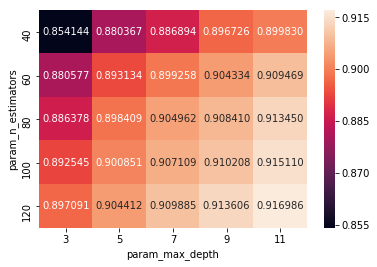

In [13]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [14]:
clf = RandomForestClassifier(n_estimators=optimal_estimator, class_weight ='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 2.4 Confusion Matrix

Confusion Matrix:


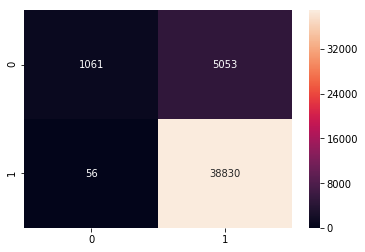

In [15]:
cm_bow=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [16]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 1061 
 false positives are 5053 
 false negatives are 56
 true positives are 38830 
 


## 2.5 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [17]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# evaluating accuracy
acc_bow = accuracy_score(y_test, y_pred) * 100
print('\nTest Accuracy of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, acc_bow))

# Error on test data
test_error_bow = 100-acc_bow
print("\nTest Error RandomForest for base learner and optimal_depth  is  %f%%" % (test_error_bow))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, recall_score))

# evaluating Classification Report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report for base learner and optimal_depth   \n\n ',(classification_report))


Test Accuracy of the RandomForest for base_learners =120, depth =11 is accuracy 88.64666666666666

Test Error RandomForest for base learner and optimal_depth  is  11.353333%

The Test Precision of the RandomForest for base_learners =120, depth =11 is accuracy 0.8848529043137434

The Test Recall of the RandomForest for base_learners =120, depth =11 is accuracy 0.9985598930206244

The Test classification report for base learner and optimal_depth   

                precision    recall  f1-score   support

           0       0.95      0.17      0.29      6114
           1       0.88      1.00      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.92      0.59      0.62     45000
weighted avg       0.89      0.89      0.85     45000



## 2.6 Plotting roc_auc curve

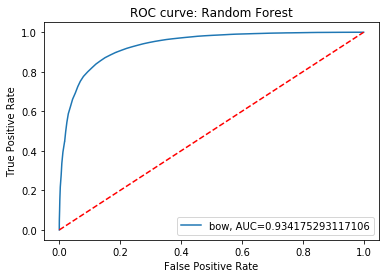

In [18]:
y_pred_proba = clf.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="bow, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: Random Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2.7 Top 25 words 

In [19]:
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_25 = likelihood_df.sort_values(by='Score',ascending=False).iloc[:25]
top_25.reset_index(inplace=True)
top_words = top_25['index']
print(top_words)

0          great
1           love
2           best
3     disappoint
4         delici
5           good
6           tast
7        perfect
8          would
9        product
10           bad
11          find
12         excel
13          like
14         money
15       favorit
16          wast
17       thought
18           use
19         didnt
20          easi
21          make
22          nice
23        wonder
24        flavor
Name: index, dtype: object




Word Cloud for Important features


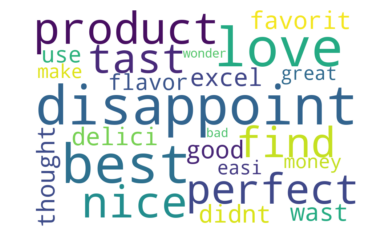

In [20]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(top_words)

wc = WordCloud(background_color="white", max_words=len(top_words), 
               width=900, height=600, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3.Applying GBDT Algorithm

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

Learning_rate = [0.05,0.1,0.2,0.3]
depth=[3,5,7,9,11]
param_grid = {'max_depth':depth, 'learning_rate':Learning_rate}
gb = GradientBoostingClassifier(loss='deviance',max_features='sqrt',subsample=0.1,n_estimators=100)
model = GridSearchCV(gb, param_grid, scoring = 'f1', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))
a = model.best_params_
optimal_learningrate = a.get('learning_rate')
optimal_depth = a.get('max_depth')


Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=11,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy of the model :  0.9409884855581576


In [22]:
results = model.cv_results_
meanscore=results['mean_test_score']

## Heatmap for plotting CV Scores

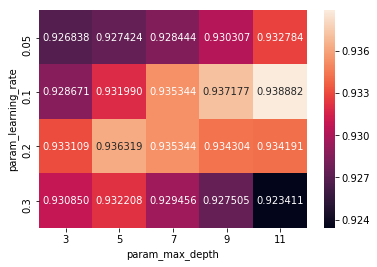

In [23]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score', index='param_learning_rate', columns='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [24]:
clf = GradientBoostingClassifier(max_depth=optimal_depth,learning_rate=optimal_learningrate, max_features='sqrt', subsample=0.1)
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 3.1 Confusion Matrix

Confusion Matrix:


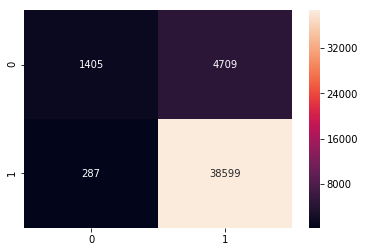

In [25]:
## Confusion Matrix:
cm_bow=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [26]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 1405 
 false positives are 4709 
 false negatives are 287
 true positives are 38599 
 


## 3.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [27]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# evaluating accuracy
acc_bow = accuracy_score(y_test, y_pred) * 100
print('\nTest Accuracy of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, acc_bow))

# Error on test data
test_error_bow = 100-acc_bow
print("\nTest Error GBDT for maxdepth and Learning_rate is  %f%%" % (test_error_bow))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, recall_score))

# evaluating Classification Report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report for GBDT maxdepth and Learning_rate   \n\n ',(classification_report))


Test Accuracy of the GBDT for maxdepth=11, Learning_rate =0.1 is accuracy 88.89777777777778

Test Error GBDT for maxdepth and Learning_rate is  11.102222%

The Test Precision of the GBDT for maxdepth=11, Learning_rate =0.1 is accuracy 0.8912672023644592

The Test Recall of the GBDT for maxdepth=11, Learning_rate =0.1 is accuracy 0.9926194517307

The Test classification report for GBDT maxdepth and Learning_rate   

                precision    recall  f1-score   support

           0       0.83      0.23      0.36      6114
           1       0.89      0.99      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.86      0.61      0.65     45000
weighted avg       0.88      0.89      0.86     45000



## 3.3 Plotting roc_auc curve

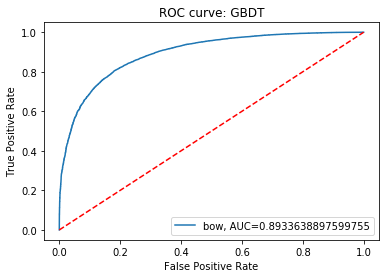

In [28]:
y_pred_proba = clf.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="bow, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: GBDT')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3.4 Top 25 words 

In [29]:
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_25 = likelihood_df.sort_values(by='Score',ascending=False).iloc[:25]
top_25.reset_index(inplace=True)
top_words = top_25['index']
print(top_words)

0     disappoint
1          great
2        terribl
3           wast
4            bad
5          worst
6           love
7        horribl
8        thought
9           best
10          tast
11         would
12         threw
13         money
14            aw
15         didnt
16        return
17        delici
18         stale
19        receiv
20       wouldnt
21         gross
22          poor
23          list
24       product
Name: index, dtype: object




Word Cloud for Important features


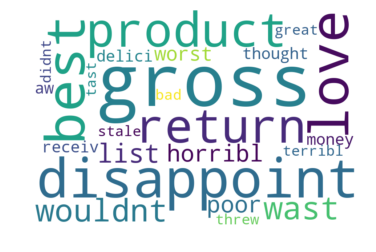

In [30]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(top_words)

wc = WordCloud(background_color="white", max_words=len(top_words), 
               width=900, height=600, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 4. TF-IDF

In [31]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()

final_counts_tfidf_tr= tf_idf_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(final_counts_tfidf_tr))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_tr.get_shape())
print("the number of unique words ", final_counts_tfidf_tr.get_shape()[1])
final_counts_tfidf_test= tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_tfidf_test))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_test.get_shape())
print("the number of unique words ", final_counts_tfidf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (105000, 38300)
the number of unique words  38300
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (45000, 38300)
the number of unique words  38300


## 4.1 Normalizing Data

In [32]:
# Data-preprocessing: Normalizing Data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_tfidf_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_tfidf_test)
print(standardized_data_test.shape)

(105000, 38300)
(45000, 38300)


## 4.2 Applying RandomForest Algorithm

In [33]:
# Gridsearch Cross Validation

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

base_learners = [40,60,80,100,120]
depth=[3,5,7,9,11]
param_grid = {'n_estimators': base_learners,'max_depth':depth}
rf = RandomForestClassifier(min_samples_leaf=5,max_features='sqrt',criterion='gini',random_state = 100,class_weight ='balanced')
model = GridSearchCV(rf, param_grid,scoring ='f1',cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train,y_train)
print(model.best_score_, model.best_params_) 
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))

a = model.best_params_
optimal_estimator = a.get('n_estimators')
optimal_depth = a.get('max_depth')

0.9127876758692683 {'max_depth': 11, 'n_estimators': 120}
Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=11, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)
Accuracy of the model :  0.910332405876581


In [34]:
results = model.cv_results_
meanscore=results['mean_test_score']

## Heatmap for Plotting CV Scores

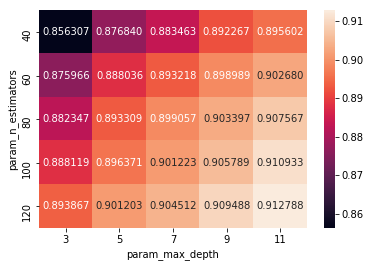

In [35]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [36]:
clf = RandomForestClassifier(n_estimators=optimal_estimator, class_weight ='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 4.3 Confusion Matrix

Confusion Matrix:


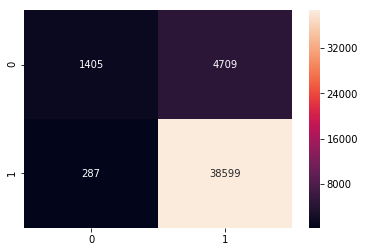

In [37]:
cm_tfidf=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [38]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 1139 
 false positives are 4975 
 false negatives are 67
 true positives are 38819 
 


## 4.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [39]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidf = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, acc_tfidf))

# Error on test data
test_error_tfidf = 100-acc_tfidf
print("\nTest Error of the RandomForest for optimal_depth  %f%%" % (test_error_tfidf))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the RandomForest for optimal_depth is \n\n ',(classification_report))


The Test Accuracy of the RandomForest for base_learners =120, depth =11 is accuracy 88.79555555555557

Test Error of the RandomForest for optimal_depth  11.204444%

The Test Precision of the RandomForest for base_learners =120, depth =11 is accuracy 0.8863999634653149

The Test Recall of the RandomForest for base_learners =120, depth =11 is accuracy 0.9982770148639614

The Test classification report of the RandomForest for optimal_depth is 

                precision    recall  f1-score   support

           0       0.94      0.19      0.31      6114
           1       0.89      1.00      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.92      0.59      0.63     45000
weighted avg       0.89      0.89      0.85     45000



## 4.5  Plotting roc_auc curve

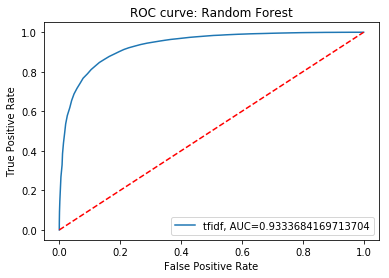

In [40]:
y_pred_proba = clf.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="tfidf, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: Random Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 4.6 Top 25 words

In [41]:
words = tf_idf_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_25 = likelihood_df.sort_values(by='Score',ascending=False).iloc[:25]
top_25.reset_index(inplace=True)
top_words = top_25['index']
print(top_words)

0          great
1           love
2           best
3     disappoint
4         delici
5           good
6            bad
7          would
8        perfect
9           tast
10       product
11          find
12         money
13       favorit
14          like
15           use
16       thought
17          make
18        return
19       terribl
20         excel
21          nice
22         didnt
23        wonder
24       horribl
Name: index, dtype: object




Word Cloud for Important features


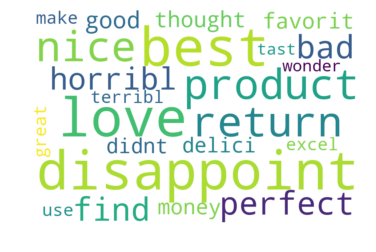

In [42]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(top_words)

wc = WordCloud(background_color="white", max_words=len(top_words), 
               width=900, height=600, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 5.Applying GBDT Algorithm

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

Learning_rate = [0.05,0.1,0.2,0.3]
depth=[3,5,7,9,11]
param_grid = {'max_depth':depth, 'learning_rate':Learning_rate}
gb = GradientBoostingClassifier(loss='deviance',max_features='sqrt',subsample=0.1,n_estimators=100)
model = GridSearchCV(gb, param_grid, scoring = 'f1', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))
a = model.best_params_
optimal_learningrate = a.get('learning_rate')
optimal_depth = a.get('max_depth')


Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=11,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy of the model :  0.9404039665716443


In [44]:
results = model.cv_results_
meanscore=results['mean_test_score']

## Heatmap for plotting CV Scores

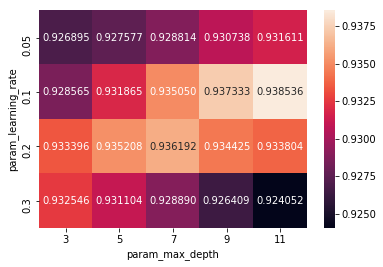

In [45]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score', index='param_learning_rate', columns='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [46]:
clf = GradientBoostingClassifier(max_depth=optimal_depth,learning_rate=optimal_learningrate, max_features='sqrt', subsample=0.1)
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 5.1 Confusion Matrix

In [47]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 1139 
 false positives are 4975 
 false negatives are 67
 true positives are 38819 
 


## 5.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [48]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidf = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, acc_tfidf))

# Error on test data
test_error_tfidf = 100-acc_tfidf
print("\nTest Error of the GBDT for maxdepth and Learning_rate %f%%" % (test_error_tfidf))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the GBDT for maxdepth and Learning_rate is \n\n ',(classification_report))


The Test Accuracy of the GBDT for maxdepth=11, Learning_rate =0.1 is accuracy 88.95555555555555

Test Error of the GBDT for maxdepth and Learning_rate 11.044444%

The Test Precision of the GBDT for maxdepth=11, Learning_rate =0.1 is accuracy 0.8913324410393686

The Test Recall of the GBDT for maxdepth=11, Learning_rate =0.1 is accuracy 0.9932880728282673

The Test classification report of the GBDT for maxdepth and Learning_rate is 

                precision    recall  f1-score   support

           0       0.84      0.23      0.36      6114
           1       0.89      0.99      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.87      0.61      0.65     45000
weighted avg       0.88      0.89      0.86     45000



## 5.3  Plotting roc_auc curve

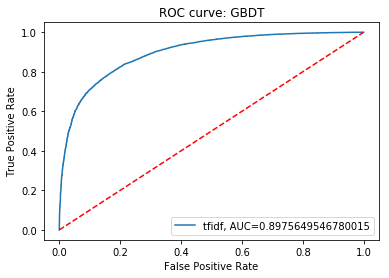

In [49]:
y_pred_proba = clf.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="tfidf, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: GBDT')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 5.4 Top 25 words

In [50]:
words = tf_idf_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_25 = likelihood_df.sort_values(by='Score',ascending=False).iloc[:25]
top_25.reset_index(inplace=True)
top_words = top_25['index']
print(top_words)

0     disappoint
1          great
2            bad
3        horribl
4         return
5           best
6          threw
7           love
8        thought
9          didnt
10         money
11         would
12          wast
13            aw
14       terribl
15         stale
16        refund
17      unfortun
18         worst
19        delici
20          good
21        pictur
22         throw
23        receiv
24          mayb
Name: index, dtype: object




Word Cloud for Important features


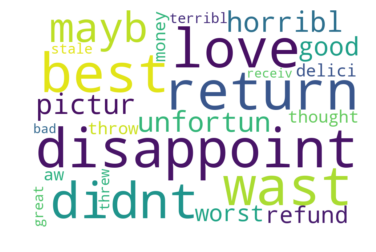

In [51]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(top_words)

wc = WordCloud(background_color="white", max_words=len(top_words), 
               width=900, height=600, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 6. WORD2VEC

In [52]:
from gensim.models import Word2Vec
# List of sentence in X_train text
sent_of_train=[]
for sent in x_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in x_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  12829


## 7.  Avg Word2Vec


In [53]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)

## 7.1 Standardizing Data

In [54]:
# Data-preprocessing: Normalizing Data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(train_vectors)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(test_vectors)
print(standardized_data_test.shape)


(105000, 50)
(45000, 50)


## 7.2 Applying RandomForest Algorithm


In [55]:
# Gridsearch Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

base_learners = [40,60,80,100,120]
depth=[3,5,7,9,11]
param_grid = {'n_estimators': base_learners,'max_depth':depth}
rf = RandomForestClassifier(min_samples_leaf=5,max_features='sqrt',criterion='gini',random_state = 100,class_weight ='balanced')
model = GridSearchCV(rf, param_grid,scoring ='f1',cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train,y_train)
print(model.best_score_, model.best_params_) 
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))

a = model.best_params_
optimal_estimator = a.get('n_estimators')
optimal_depth = a.get('max_depth')

0.9235738058587347 {'max_depth': 11, 'n_estimators': 120}
Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=11, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)
Accuracy of the model :  0.9181707187599533


In [56]:
results = model.cv_results_
meanscore=results['mean_test_score']

## Heatmap for plotting CV Scores

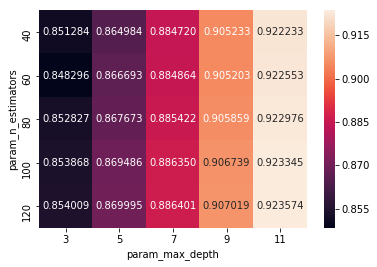

In [57]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [58]:
clf = RandomForestClassifier(n_estimators=optimal_estimator, class_weight ='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 7.3 Confusion Matrix

Confusion Matrix:


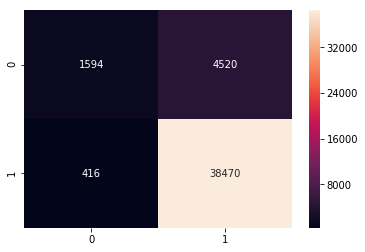

In [59]:
cm_avgw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_avgw2v, annot=True, fmt='d')
plt.show()

In [60]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avgw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 1594 
 false positives are 4520 
 false negatives are 416
 true positives are 38470 
 


## 7.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [61]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_avgw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy  of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, acc_avgw2v))

# Error on test data
test_error_avgw2v = 100-acc_avgw2v
print("\nTest Error of the RandomForest for optimal_estimator,optimal_depth is  %f%%" % (test_error_avgw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision  of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall  of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the RandomForest for optimal_estimator,optimal_depth is \n\n ',(classification_report))


The Test Accuracy  of the RandomForest for base_learners =120, depth =11 is accuracy 89.03111111111112

Test Error of the RandomForest for optimal_estimator,optimal_depth is  10.968889%

The Test Precision  of the RandomForest for base_learners =120, depth =11 is accuracy 0.8948592695975809

The Test Recall  of the RandomForest for base_learners =120, depth =11 is accuracy 0.989302062438924

The Test classification report of the RandomForest for optimal_estimator,optimal_depth is 

                precision    recall  f1-score   support

           0       0.79      0.26      0.39      6114
           1       0.89      0.99      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.84      0.63      0.67     45000
weighted avg       0.88      0.89      0.87     45000



## 7.5 Plotting roc_auc curve

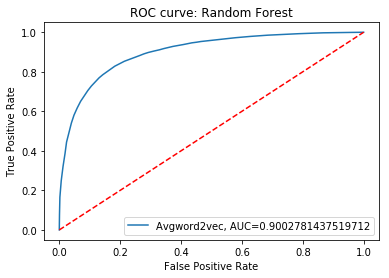

In [62]:
y_pred_proba = clf.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Avgword2vec, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: Random Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 8.Applying GBDT Algorithm

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

Learning_rate = [0.05,0.1,0.2,0.3]
depth=[3,5,7,9,11]
param_grid = {'max_depth':depth, 'learning_rate':Learning_rate}
gb = GradientBoostingClassifier(loss='deviance',max_features='sqrt',subsample=0.1,n_estimators=100)
model = GridSearchCV(gb, param_grid, scoring = 'f1', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))
a = model.best_params_
optimal_learningrate = a.get('learning_rate')
optimal_depth = a.get('max_depth')


Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=7,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy of the model :  0.9425643440439163


In [64]:
results = model.cv_results_
meanscore=results['mean_test_score']

## Heatmap for plotting CV Scores

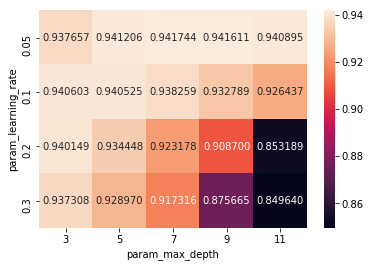

In [65]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score', index='param_learning_rate', columns='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [66]:
clf = GradientBoostingClassifier(max_depth=optimal_depth,learning_rate=optimal_learningrate, max_features='sqrt', subsample=0.1)
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 8.1 Confusion Matrix

Confusion Matrix:


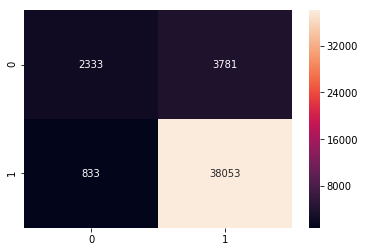

In [67]:
cm_avgw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_avgw2v, annot=True, fmt='d')
plt.show()

In [68]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avgw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 2333 
 false positives are 3781 
 false negatives are 833
 true positives are 38053 
 


## 8.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [69]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_avgw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, acc_avgw2v))

# Error on test data
test_error_avgw2v = 100-acc_avgw2v
print("\nTest Error of the GBDT for maxdepth and Learning_rate is  %f%%" % (test_error_avgw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the GBDT for maxdepth and Learning_rate \n\n ',(classification_report))



The Test Accuracy of the GBDT for maxdepth=7, Learning_rate =0.05 is accuracy 89.74666666666667

Test Error of the GBDT for maxdepth and Learning_rate is  10.253333%

The Test Precision of the GBDT for maxdepth=7, Learning_rate =0.05 is accuracy 0.9096189702156141

The Test Recall of the GBDT for maxdepth=7, Learning_rate =0.05 is accuracy 0.9785784086817878

The Test classification report of the GBDT for maxdepth and Learning_rate 

                precision    recall  f1-score   support

           0       0.74      0.38      0.50      6114
           1       0.91      0.98      0.94     38886

   micro avg       0.90      0.90      0.90     45000
   macro avg       0.82      0.68      0.72     45000
weighted avg       0.89      0.90      0.88     45000



## 8.3 Plotting roc_auc curve

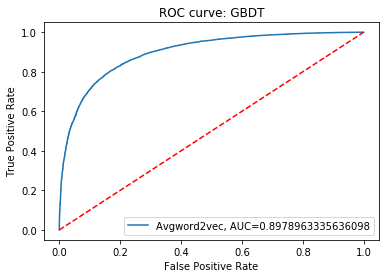

In [70]:
y_pred_proba = clf.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Avgword2vec, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: GBDT')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 9. TFIDF-Word2Vec

In [71]:
#tf-idf weighted w2v

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfw2v_vect = TfidfVectorizer()
final_counts_tfidfw2v_train= tfidfw2v_vect.fit_transform(x_train) 
print(type(final_counts_tfidfw2v_train))
print(final_counts_tfidfw2v_train.shape)

final_counts_tfidfw2v_test= tfidfw2v_vect.transform(x_test) 
print(type(final_counts_tfidfw2v_test))
print(final_counts_tfidfw2v_test.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(105000, 38300)
<class 'scipy.sparse.csr.csr_matrix'>
(45000, 38300)


In [72]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidfw2v_vect.get_feature_names(), list(tfidfw2v_vect.idf_)))


# TF-IDF weighted Word2Vec
tfidf_feat = tfidfw2v_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

#Test case

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors1))

105000
45000


## 9.1 Normalizing Data

In [73]:
# Data-preprocessing: Normalizing Data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(tfidf_sent_vectors)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(tfidf_sent_vectors1)
print(standardized_data_test.shape)

(105000, 50)
(45000, 50)


## 9.2 Applying RandomForest Algorithm


In [74]:
#Gridsearch Cross Validation

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

base_learners = [40,60,80,100,120]
depth=[3,5,7,9,11]
param_grid = {'n_estimators': base_learners,'max_depth':depth}
rf = RandomForestClassifier(min_samples_leaf=5,max_features='sqrt',criterion='gini',random_state = 100,class_weight ='balanced')
model = GridSearchCV(rf, param_grid,scoring ='f1',cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train,y_train)
print(model.best_score_, model.best_params_) 
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))

a = model.best_params_
optimal_estimator = a.get('n_estimators')
optimal_depth = a.get('max_depth')

0.9196179232555778 {'max_depth': 11, 'n_estimators': 120}
Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=11, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)
Accuracy of the model :  0.9149292947964668


In [75]:
results = model.cv_results_
meanscore=results['mean_test_score']

## Heatmap for Plotting CV Scores

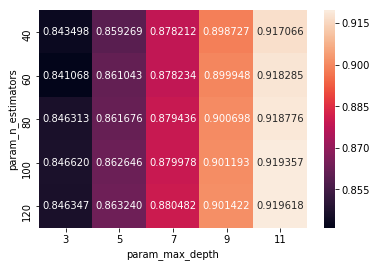

In [76]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [77]:
clf = RandomForestClassifier(n_estimators=optimal_estimator, class_weight ='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 9.3 Confusion Matrix

Confusion Matrix:


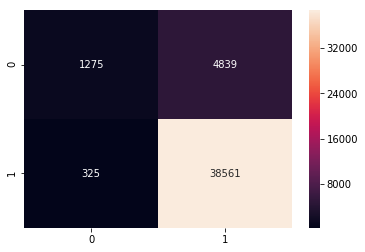

In [78]:
cm_tfidfw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_tfidfw2v, annot=True, fmt='d')
plt.show()

In [79]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidfw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 1275 
 false positives are 4839 
 false negatives are 325
 true positives are 38561 
 


## 9.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [80]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

# evaluating accuracy
acc_tfidfw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, acc_tfidfw2v))

# Error on test data
test_error_tfidfw2v = 100-acc_tfidfw2v
print("\nTest Error of the RandomForest for maxdepth is  %f%%" % (test_error_tfidfw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the RandomForest for base_learners ={}, depth ={} is accuracy {}'.format(optimal_estimator,optimal_depth, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the RandomForest for maxdepth is \n\n ',(classification_report))


The Test Accuracy of the RandomForest for base_learners =120, depth =11 is accuracy 88.52444444444444

Test Error of the RandomForest for maxdepth is  11.475556%

The Test Precision of the RandomForest for base_learners =120, depth =11 is accuracy 0.8885023041474654

The Test Recall of the RandomForest for base_learners =120, depth =11 is accuracy 0.9916422362804094

The Test classification report of the RandomForest for maxdepth is 

                precision    recall  f1-score   support

           0       0.80      0.21      0.33      6114
           1       0.89      0.99      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.84      0.60      0.63     45000
weighted avg       0.88      0.89      0.85     45000



## 9.5 Plotting roc_auc curve


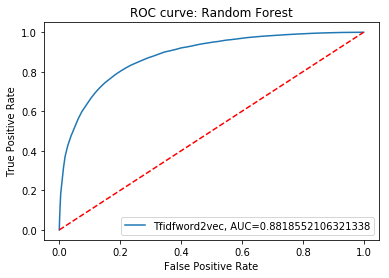

In [81]:
y_pred_proba = clf.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Tfidfword2vec, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: Random Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 10.Applying GBDT Algorithm

In [82]:
from sklearn.ensemble import GradientBoostingClassifier

Learning_rate = [0.05,0.1,0.2,0.3]
depth=[3,5,7,9,11]
param_grid = {'max_depth':depth, 'learning_rate':Learning_rate}
gb = GradientBoostingClassifier(loss='deviance',max_features='sqrt',subsample=0.1,n_estimators=100)
model = GridSearchCV(gb, param_grid, scoring = 'f1', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(standardized_data_train,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(standardized_data_test, y_test))
a = model.best_params_
optimal_learningrate = a.get('learning_rate')
optimal_depth = a.get('max_depth')


Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy of the model :  0.9384902258610256


In [83]:
results = model.cv_results_
meanscore=results['mean_test_score']

## Heatmap for plotting CV Scores

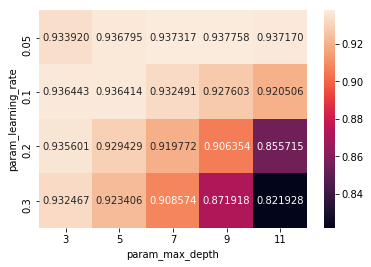

In [84]:
pvt =pd.pivot_table(pd.DataFrame(model.cv_results_),values='mean_test_score', index='param_learning_rate', columns='param_max_depth')
import seaborn as sns       
ax = sns.heatmap(pvt,annot=True,fmt="f")

In [85]:
clf = GradientBoostingClassifier(max_depth=optimal_depth,learning_rate=optimal_learningrate, max_features='sqrt', subsample=0.1)
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 10.1 Confusion Matrix

Confusion Matrix:


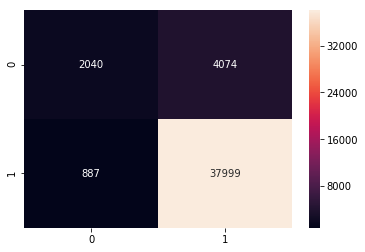

In [86]:
cm_tfidfw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_tfidfw2v, annot=True, fmt='d')
plt.show()

In [87]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidfw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 2040 
 false positives are 4074 
 false negatives are 887
 true positives are 37999 
 


## 10.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [88]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

# evaluating accuracy
acc_tfidfw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, acc_tfidfw2v))

# Error on test data
test_error_tfidfw2v = 100-acc_tfidfw2v
print("\nTest Error of the GBDT for maxdepth and Learning_rate  %f%%" % (test_error_tfidfw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the GBDT for maxdepth={}, Learning_rate ={} is accuracy {}'.format(optimal_depth,optimal_learningrate, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the GBDT for maxdepth and Learning_rate \n\n ',(classification_report))


The Test Accuracy of the GBDT for maxdepth=9, Learning_rate =0.05 is accuracy 88.97555555555556

Test Error of the GBDT for maxdepth and Learning_rate  11.024444%

The Test Precision of the GBDT for maxdepth=9, Learning_rate =0.05 is accuracy 0.903168302711953

The Test Recall of the GBDT for maxdepth=9, Learning_rate =0.05 is accuracy 0.9771897340945327

The Test classification report of the GBDT for maxdepth and Learning_rate 

                precision    recall  f1-score   support

           0       0.70      0.33      0.45      6114
           1       0.90      0.98      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.80      0.66      0.69     45000
weighted avg       0.88      0.89      0.87     45000



## 10.3 Plotting roc_auc curve


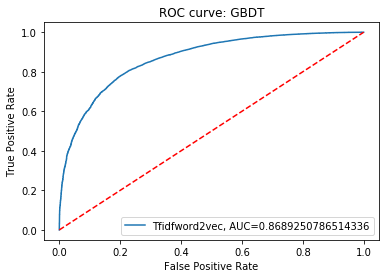

In [89]:
y_pred_proba = clf.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Tfidfword2vec, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: GBDT')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 11. Conclusion

-----------------------------------------------------------------------------------------------------------------------
|
  Model Performance Table                                                                                                       

-----------------------------------------------------------------------------------------------------------------------
|           Model                    |       Depth           | base learner | Test Error   | Accuracy  |
|:----------------------------------:|:---------------------:|:------------:|:------------:|:---------:|
| Random Forest with Bow             |         11            |   120        |11.353333     |88.6466666 |
| Random Forest with Tfidf           |         11            |   120        |11.204444     |88.7955555 |
| Random Forest with Avgw2v          |         11            |   120        |10.968889     |89.0311111 |
| Random Forest with Tfidfw2v        |         11            |   120        |11.475556     |88.5244444 |

-----------------------------------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------------------------------
|
  Model Performance Table                                                                                                       

-----------------------------------------------------------------------------------------------------------------------
|           Model                    |       Depth            |learning rate | Test Error   | Accuracy  |
|:----------------------------------:|:----------------------:|:------------:|:------------:|:---------:|
| GBDT with Bow                      |         11             |   0.1        |11.102222     |88.897777  |
| GBDT with Tfidf                    |         11             |   0.1        |11.044444     |88.955555  |
| GBDT with Avgw2v                   |         7              |   0.05       |10.253333     |89.746666  |
| GBDT with Tfidfw2v                 |         3              |   0.05       |11.024444     |88.975555  |

-----------------------------------------------------------------------------------------------------------------------

Steps Involved:-

1) Connecting SQL file

2) Data Preprocessing(Already i had done preprocessing no need to do again)

3) Sorting the data based on time

4) Taking 1st 150K Rows (Due to low Ram)

5) Spliting data into train and test based on time (70:30)

6) Techniques For Vectorization Bow,TF-IDF,word2vec,Avgword2vec,tfidfword2vec.

7) Normalizing Data 

8) Applying Random Forest Algorithm

9) Introduced heatmap for cv_results vs max_deth vs base learner

10) I calculated Accuracy,Error on Test Data, Confusion Matrix,Precision Score,Recall Score,Classification Report,ROC_curve

11) Calculated top features and builded a word cloud

12) Applying GradientBoostingClassifier

13) Introduced heatmap for cv_results vs max_deth vs learning rate

12) I calculated Accuracy,Error on Test Data, Confusion Matrix,Precision Score,Recall Score,Classification Report,ROC_curve

13) Conclusion